In [1]:
from torch.optim import Adam, SGD
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn import preprocessing
from inverse_modelling_tfo.models import train_model, train_model_wtih_reporting
from inverse_modelling_tfo.data import generate_data_loaders, equidistance_detector_normalization, constant_detector_count_normalization
from inverse_modelling_tfo.data.intensity_interpolation import get_interpolate_fit_params_custom, interpolate_exp
from inverse_modelling_tfo.data.interpolation_function_zoo import *
from inverse_modelling_tfo.models import RandomSplit, ValidationMethod, HoldOneOut, CVSplit
from inverse_modelling_tfo.models.custom_models import SplitChannelCNN, PerceptronReLU, PerceptronBN, PerceptronDO, PerceptronBD
from inverse_modelling_tfo.features.build_features import create_ratio, create_spatial_intensity, create_ratio_and_intensity
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
import torchinfo
from inverse_modelling_tfo.misc.misc_training import set_seed
# Set my GPU
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
# Combine data from two different storages
RAW_DATA_PATH_NEW = r'/home/rraiyan/personal_projects/tfo_inverse_modelling/inverse_modelling_tfo/s_based_intensity_low_conc3.pkl'
RAW_DATA_PATH_OLD = r'/home/rraiyan/personal_projects/tfo_inverse_modelling/data/intensity/s_based_intensity_low_conc2.pkl'

data = pd.concat([pd.read_pickle(RAW_DATA_PATH_OLD), pd.read_pickle(RAW_DATA_PATH_NEW)], axis=0, ignore_index=True)
# Pre-processing
equidistance_detector_normalization(data)
data["Intensity"] = np.log10(data["Intensity"])

# Convert to Spatial Form
data = create_spatial_intensity(data)

# Drop Thickness values which I did not calculate the close concnetration points
data = data[(data["Maternal Wall Thickness"] >= 2.0) & (data["Maternal Wall Thickness"] <= 12.0)]
# Drop Uterus Thickness for now
data = data.drop(columns='Uterus Thickness')


data.head()

,Maternal Wall Thickness,Maternal Hb Concentration,Maternal Saturation,Fetal Hb Concentration,Fetal Saturation,10_1.0,14_1.0,19_1.0,23_1.0,28_1.0,...,55_2.0,59_2.0,64_2.0,68_2.0,73_2.0,77_2.0,82_2.0,86_2.0,91_2.0,95_2.0
0,2.0,11.9,0.9,0.1,0.100,-4.782237,-5.879136,-6.547801,-7.000671,-7.387554,...,-11.398604,-11.677435,-11.928764,-12.176000,-12.432485,-12.681307,-12.967372,-13.182160,-13.374700,-13.686308
1,2.0,11.9,0.9,0.1,0.225,-4.781698,-5.874885,-6.537533,-6.984695,-7.366289,...,-11.421499,-11.703210,-11.956930,-12.207563,-12.466490,-12.717965,-13.007502,-13.224262,-13.416960,-13.732636
2,2.0,11.9,0.9,0.1,0.350,-4.781127,-5.870365,-6.526591,-6.967610,-7.343423,...,-11.443808,-11.728306,-11.984335,-12.238319,-12.499601,-12.753615,-13.046488,-13.265231,-13.458059,-13.777716
3,2.0,11.9,0.9,0.1,0.475,-4.780518,-5.865534,-6.514869,-6.949231,-7.318680,...,-11.465549,-11.752739,-12.010998,-12.268283,-12.531835,-12.788268,-13.084341,-13.305079,-13.498012,-13.821551
4,2.0,11.9,0.9,0.1,0.600,-4.779865,-5.860340,-6.502224,-6.929318,-7.291693,...,-11.486738,-11.776525,-12.036935,-12.297468,-12.563207,-12.821937,-13.121069,-13.343812,-13.536832,-13.864148


In [17]:
a = data['Fetal Hb Concentration'].value_counts()
a = list(a.index)
a = [round(x * 5, 1) for x in a]
a

[0.6, 0.6, 0.7, 0.8, 0.9, 0.5, 0.6, 0.7, 0.7, 0.8]

In [18]:
a= list(data['Fetal Hb Concentration'].value_counts().index)
b = list(data['Maternal Hb Concentration'].value_counts().index)
print(a)
print(b)

[0.11, 0.125, 0.14, 0.15500000000000003, 0.17, 0.1, 0.115, 0.13, 0.14500000000000002, 0.16]
[11.9, 12.9, 15.9, 13.9, 14.9, 14.2, 16.1, 16.0, 15.2, 15.100000000000001, 15.0, 14.100000000000001, 12.0, 14.0, 13.2, 13.1, 13.0, 12.2, 12.1, 16.2]


In [3]:
# Create two additional rows to help with grouping - gives same values to similar/close saturations 
data['MconcCenters'] = np.round(data['Maternal Hb Concentration']).astype(int)
data['FconcCenters'] = np.round(data['Fetal Hb Concentration'] * 5, 1)

In [4]:
useful_fixed_columns = ['Maternal Wall Thickness', 'Maternal Saturation', 'Fetal Saturation']
fixed_columns = useful_fixed_columns + ['MconcCenters', 'FconcCenters'] # only the first ones are used as labels/the rest 2 are for grouping purposes
variable_columns = ['Maternal Hb Concentration', 'Fetal Hb Concentration']
x_columns = list(filter(lambda X: X.isdigit(), data.columns)) + list(filter(lambda X: '_' in X, data.columns))

In [5]:
m = data.groupby(fixed_columns)

array([ 2, 10,  5,  8])

In [22]:
from itertools import permutations
new_rows = []
for key, data_group in m:
    # Create all possible permuations of 2 rows indices the given data_group
    index_pairs = permutations(list(range(len(data_group))), 2)
    for i, j in index_pairs:
        new_row = np.hstack([data_group.loc[:, x_columns].iloc[i, :], data_group.loc[:, x_columns].iloc[j, :], key[:len(useful_fixed_columns)], data_group.loc[:, variable_columns].iloc[i, :], data_group.loc[:, variable_columns].iloc[j, :]])
        new_rows.append(new_row)
new_rows = np.array(new_rows)

In [23]:
# Generate Column names
# Combining two rows into one creates 2x input features - named as x_n
feature_columns = [f'x_{n}' for n in range(2 * len(x_columns))]
# Combininig two rows creates 2 sets of the variable columns - named var 1 and var 2 for each var
new_variable_columns = [f'{var} 1' for var in variable_columns] + [f'{var} 2' for var in variable_columns]
labels = useful_fixed_columns + new_variable_columns

In [24]:
# Create the dataframe
data = pd.DataFrame(data=new_rows, columns=feature_columns + labels)

## Normalizing Features
x_columns will be the input features and y_columns are the target

In [25]:
## Y -> Target
## Scale y
y_scaler = preprocessing.StandardScaler()
data[labels] = y_scaler.fit_transform(data[labels])

## Scale x
x_scaler = preprocessing.StandardScaler()
data[feature_columns] = x_scaler.fit_transform(data[feature_columns])

## Model Configuration

In [26]:
IN_FEATURES = len(feature_columns)
OUT_FEATURES = len(labels)

from inverse_modelling_tfo.models.train_model import ModelTrainerFactory
datagen_kw = {
    'table' : data,
    'data_loader_params' : 
        {
            'batch_size': 64, 'shuffle': True, 'num_workers': 2
        }, 
    'x_columns': feature_columns,
    'y_columns': labels,
    'validation_method' : HoldOneOut('Maternal Wall Thickness', data['Maternal Wall Thickness'].unique()[3])
    # 'validation_method' : HoldOneOut('Maternal Hb Concentration', 13.0)
    # 'validation_method' : HoldOneOut('Maternal Saturation', 1.0)
}
trainer_factory = ModelTrainerFactory(PerceptronBD, {'node_counts' : [IN_FEATURES, 20, 10, OUT_FEATURES], 'dropout_rates': [0.01, 0.01]}, generate_data_loaders, datagen_kw, 100, nn.MSELoss())

## Hyper Parameter Tuning

In [27]:
# Custom Train Function 
def train_with_tuning(iteration_config):
    set_seed(42)
    trainer_tuning = trainer_factory.create()
    trainer_tuning.reporting = True     # Report at each epoch to Ray Tune
    if 'batch_size' in iteration_config:
        trainer_tuning.change_batch_size(iteration_config['batch_size'])    # If batch_size needs tuning
    trainer_tuning.set_optimizer(SGD, {'lr': iteration_config["lr"], 'momentum': iteration_config["momentum"]})
    trainer_tuning.run()

In [28]:
# # Hyper Parameter Search 
# iteration_config = {
#     "lr" : tune.loguniform(1e-4, 1e-2),
#     # "batch_size": tune.choice([128, 256]),
#     "momentum": tune.uniform(0.9, 0.99),
# }
# scheduler = ASHAScheduler(metric="combined_loss", mode="min", max_t=60, grace_period=5, reduction_factor=2)
# reporter = CLIReporter(metric_columns=["train_loss", "val_loss", "combined_loss", "training_iteration"])
# result = tune.run(train_with_tuning, config=iteration_config, scheduler=scheduler, progress_reporter=reporter,
#                   num_samples=80, resources_per_trial={"cpu": 0, "gpu": 0.5},)

# best_trial = result.get_best_trial("combined_loss", "min", "last")
# print("Best trial config: {}".format(best_trial.config))
# print("Best trial final validation loss: {}".format(best_trial.last_result["val_loss"]))
# print("Best trial final train loss: {}".format(best_trial.last_result["train_loss"]))


In [29]:
# best_trial.config

## Custom Training

In [30]:
set_seed(42)
trainer = trainer_factory.create()
trainer.change_batch_size(16)
# trainer.set_optimizer(SGD, {'lr': best_trial.config['lr'], 'momentum': best_trial.config['lr']["momentum"]})
trainer.set_optimizer(SGD, {'lr': 1e-4, 'momentum': 0.90})
trainer.epochs = 20
trainer.run()

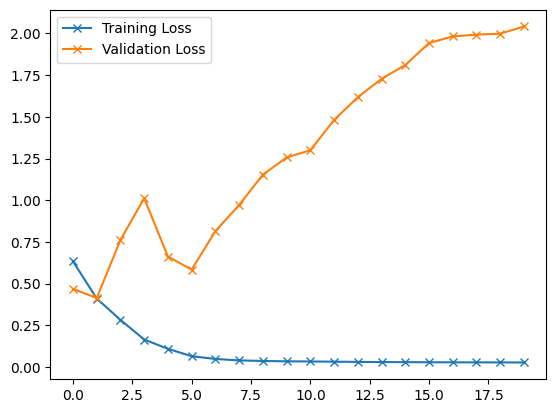

In [31]:
plt.figure()
plt.plot(trainer.train_loss, label='Training Loss', marker='x')
plt.plot(trainer.validation_loss, label='Validation Loss', marker='x')
# plt.yscale('log')
plt.legend()

In [32]:
print(trainer)


        Model Properties:
        PerceptronBD(
  (model): Sequential(
    (0): Linear(in_features=80, out_features=20, bias=True)
    (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout1d(p=0.01, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=10, bias=True)
    (5): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout1d(p=0.01, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=10, out_features=7, bias=True)
    (9): Flatten(start_dim=1, end_dim=-1)
  )
)
        Optimizer Properties"
        SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.0001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
        DataLoader Params: 
            Batch Size: 16
            Validation Method: Holds out fMaternal Wall Thickness columns 0.29277002188455997 for validation. The rest are used       

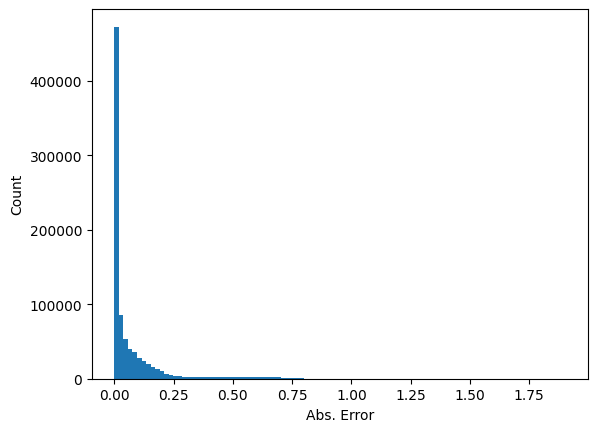

In [33]:
# Get predictions
with torch.no_grad():
    x_data = torch.tensor(data[feature_columns].values, dtype=torch.float).cuda()
    predictions = trainer.model(x_data)
    predictions = predictions.cpu().numpy()
    predictions = y_scaler.inverse_transform(predictions).flatten()
    y_data = data[labels].to_numpy()
    y_data = y_scaler.inverse_transform(y_data).flatten()
    absolute_error = np.abs(y_data - predictions)
    # error_df = pd.DataFrame({'Truth': y_data, "Predicted": predictions, "Absolute Error": absolute_error, "%tage": absolute_error/y_data * 100})
    error_df = pd.DataFrame({'Truth': y_data, "Predicted": predictions, "Absolute Error": absolute_error, "%tage": absolute_error})
plt.figure()
# error_df['%tage'].plot.hist(bins=100)
error_df['Absolute Error'].plot.hist(bins=100)
# plt.xlabel('(%) Error')
plt.xlabel('Abs. Error')
plt.ylabel('Count')
plt.show()

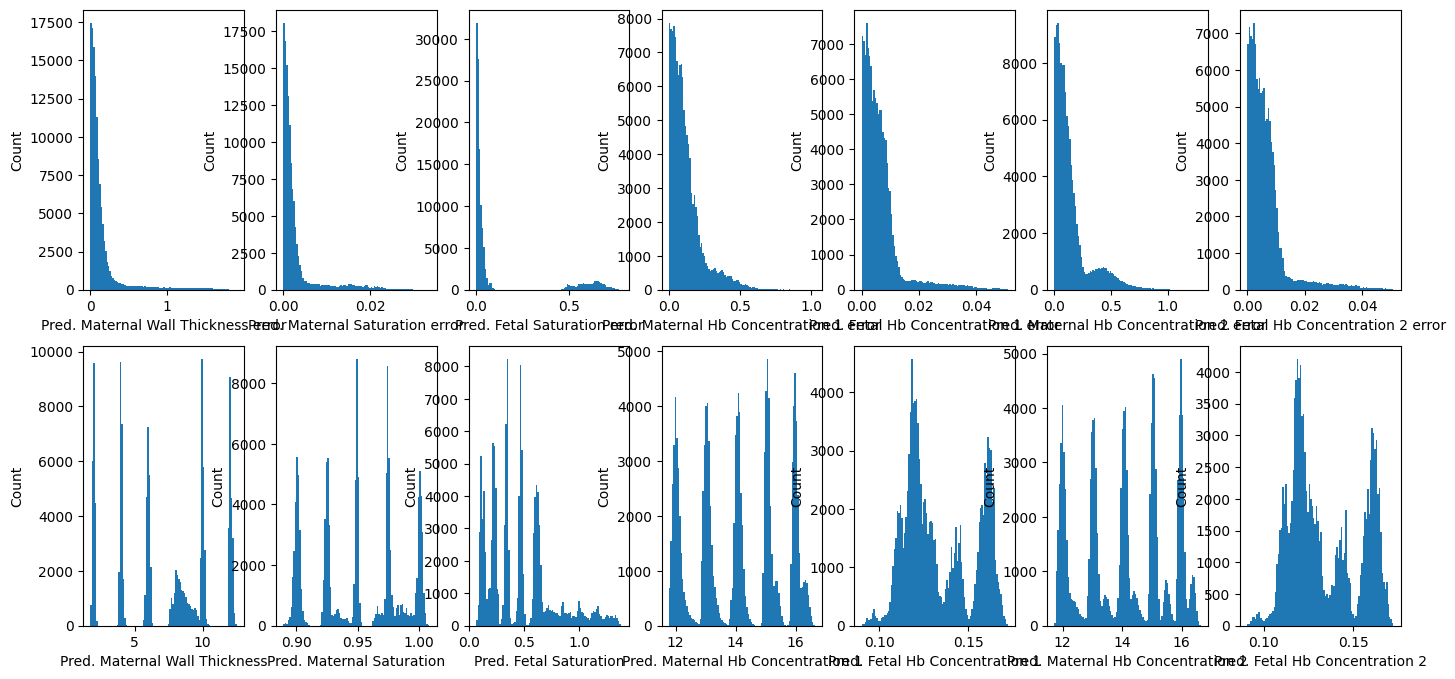

In [34]:
# Get predictions
with torch.no_grad():
    x_data = torch.tensor(data[feature_columns].values, dtype=torch.float).cuda()
    predictions = trainer.model(x_data)
    predictions = predictions.cpu().numpy()
    predictions = y_scaler.inverse_transform(predictions)
    y_data = data[labels].to_numpy()
    y_data = y_scaler.inverse_transform(y_data)

    absolute_error = np.abs(y_data - predictions)
    error_df1 = pd.DataFrame({labels[i] + ' error': absolute_error[:, i] for i in range(len(labels))})
    error_df2 = pd.DataFrame({labels[i]: predictions[:, i] for i in range(len(labels))})
    error_df = pd.DataFrame(np.column_stack([error_df1, error_df2]), columns=error_df1.columns.append(error_df2.columns))
fig, axes = plt.subplots(2, 7, squeeze=True, figsize=(17, 8))
for i in range(len(error_df.columns)):
    error_column = error_df.columns[i]
    ax = axes.flatten()[i]
    plt.sca(ax)
    error_df[error_column].plot.hist(bins=100)
    # plt.xlabel(f'Abs. {error_column} Error')
    plt.xlabel(f'Pred. {error_column}')
    plt.ylabel('Count')
# plt.xlabel("Abs. Error")
plt.show()